# Setting up Mindcontrol to QC Freesurfer Outputs

This tutorial will set up a Mindcontrol instance for Freesurfer output QC. The first step is to clone the Mindcontrol repository from GitHub and checkout the FreeSurfer branch:

```bash
git clone https://github.com/akeshavan/mindcontrol
cd mindcontrol
git checkout origin/FreeSurfer
```

Then start Mindcontrol by typing `meteor` in the mindcontrol directory:

```bash
meteor
```

Also, start the static server in another terminal window:

```bash
cd mindcontrol_docs/mindcontrol_base_dir
python start_static_server.py
```

Navigate to http://localhost:3000, you should see an empty Mindcontrol UI:

![](images/freesurfer_empty_instance.png)

## Import FreeSurfer Subjects Directory Into Mindcontrol

Freesurfer writes data in `.mgz` format, but Mindcontrol's Papaya.js viewer can only read `.nii.gz` files. We also want to split up the different parts of FreeSurfer QC (brain mask editing, wm edits, and aparc+aseg edits) into 3 sections, as shown in the empty Mindcontrol instance above. This workflow reads all the folders in the `SUBJECTS_DIR` of Freesurfer, converts all volumetric data from `.mgz` into `.nii.gz`, and parses stats files to display as histograms on the mindcontrol interface.

Lets say your directory structure looks like:

```bash
mindcontrol/ #(cloned from https://github.com/akeshavan/mindcontrol, checked out origin/FreeSurfer branch)

mindcontrol_docs/ #(cloned from https://github.com/akeshavan/mindcontrol_docs)
|___ MindPrepFS.ipynb #(this notebook)
|___ mindcontrol_base_dir/
     |___ start_static_server.py

freesurfer_subjects_dir/
|___ sub-01/
    |___ mri/
    |___ stats/
    |___ surf/
     ...
 ...
```

### Import necessary packages

We recommend installing nipype through [Anaconda](https://www.continuum.io/downloads):

```bash
conda config --add channels conda-forge
conda install -y nipype
```

Also make sure you have [FreeSurfer](https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=freesurfer+download&*) installed

In [110]:
%pylab inline
import os
import os.path as op
import nibabel as nb
from glob import glob
from IPython.display import Image
from nipype import MapNode, Workflow, Node
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.io import DataSink
from nipype.interfaces.utility import IdentityInterface, Function
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


### Set your directories

In [2]:
# Set SUBJECTS_DIR, from Freesurfer
subjects_dir = os.path.abspath("../data/ds000114/derivatives/freesurfer/")

# Set the directory to save converted Freesurfer outputs (ideally, the mindcontrol base dir)
mindcontrol_base_dir = os.path.abspath("./mindcontrol_base_dir") #this is where the static_server runs
mindcontrol_outdir = os.path.abspath("./mindcontrol_base_dir/freesurfer") 
if not os.path.exists(mindcontrol_outdir):
    os.mkdir(mindcontrol_outdir)

# Set the directory where the nipype workflow saves intermediary files
workflow_working_dir = os.path.abspath("./scratch")

After running this worflow, your directory structure will look like:

```bash
mindcontrol/ 
# you should be running "meteor" in a separate terminal window here

mindcontrol_docs/ 
|___ MindPrepFS.ipynb 
|___ mindcontrol_base_dir/
     |___ start_static_server.py
          # you should be running start_static_server.py in a separate terminal window
     |___ freesurfer/ #the workflow will create these files
         |___ sub-01/
             |___ T1.nii.gz
             |___ aparc+aseg.nii.gz
             |___ brainmask.nii.gz
             |___ wm.nii.gz
             |___ mindcontrol_entries.json
|___ scratch/ #this is the nipype working directory

freesurfer_subjects_dir/
|___ sub-01/
    |___ mri/
    |___ stats/
    |___ surf/
     ...
 ...
```

### Find all subjects in the Freesurfer directory

In [21]:
# Select subjects to prepare (this will do all inside the SUBJECTS_DIR)
subject_paths = glob(op.join(subjects_dir, "*"))

# SUBJECTS_DIR sometimes contains directories that aren't subjects, don't grab them

subjects = []
for path in subject_paths:
    subject = path.split('/')[-1]
    # check if mri dir exists, and don't add fsaverage
    if op.exists(op.join(path, 'mri')) and subject != 'fsaverage':
        subjects.append(subject)


# Volumes that will be prepared
volumes = ["brainmask.mgz", "wm.mgz", "aparc+aseg.mgz", "T1.mgz"]

### Helper functions

In [22]:
#this function finds data in the subjects_dir 
def data_grabber(subjects_dir, subject, volumes):
    import os
    volumes_list = [os.path.join(subjects_dir, subject, 'mri', volume) for volume in volumes]
    return volumes_list

In [23]:
#this function parses the aseg.stats, lh.aparc.stats and rh.aparc.stats and returns a dictionary

def parse_stats(subjects_dir, subject):
    from os.path import join, exists

    aseg_file = join(subjects_dir, subject, "stats", "aseg.stats")
    lh_aparc = join(subjects_dir, subject, "stats", "lh.aparc.stats")
    rh_aparc = join(subjects_dir, subject, "stats", "rh.aparc.stats")

    assert exists(aseg_file), "aseg file does not exists for %s" %subject
    assert exists(lh_aparc), "lh aparc file does not exists for %s" %subject
    assert exists(rh_aparc), "rh aparc file does not exists for %s" %subject

    def convert_stats_to_json(aseg_file, lh_aparc, rh_aparc):
        import pandas as pd
        import numpy as np

        def extract_other_vals_from_aseg(f):
            value_labels = ["EstimatedTotalIntraCranialVol",
                              "Mask",
                              "TotalGray",
                              "SubCortGray",
                              "Cortex",
                              "CerebralWhiteMatter",
                              "CorticalWhiteMatterVol"]
            value_labels = list(map(lambda x: 'Measure ' + x + ',', value_labels))
            output = pd.DataFrame()
            with open(f,"r") as q:
                out = q.readlines()
                relevant_entries = [x for x in out if any(v in x for v in value_labels)]
                for val in relevant_entries:
                    sname= val.split(",")[1][1:]
                    vol = val.split(",")[-2]
                    output = output.append(pd.Series({"StructName":sname,"Volume_mm3":vol}),ignore_index=True)
            return output

        df = pd.DataFrame(np.genfromtxt(aseg_file,dtype=str),columns=["Index",
                                                            "SegId",
                                                            "NVoxels",
                                                            "Volume_mm3",
                                                            "StructName",
                                                            "normMean",
                                                            "normStdDev",
                                                            "normMin",
                                                            "normMax",
                                                            "normRange"])

        df = df.append(extract_other_vals_from_aseg(aseg_file), ignore_index=True)
        
        aparc_columns = ["StructName", "NumVert", "SurfArea", "GrayVol",
                         "ThickAvg", "ThickStd", "MeanCurv", "GausCurv",
                         "FoldInd", "CurvInd"]
        tmp_lh = pd.DataFrame(np.genfromtxt(lh_aparc,dtype=str),columns=aparc_columns)
        tmp_lh["StructName"] = "lh_"+tmp_lh["StructName"]
        tmp_rh = pd.DataFrame(np.genfromtxt(rh_aparc,dtype=str),columns=aparc_columns)
        tmp_rh["StructName"] = "rh_"+tmp_rh["StructName"]

        aseg_melt = pd.melt(df[["StructName","Volume_mm3"]], id_vars=["StructName"])
        aseg_melt.rename(columns={"StructName": "name"},inplace=True)
        aseg_melt["value"] = aseg_melt["value"].astype(float)
        
        lh_aparc_melt = pd.melt(tmp_lh,id_vars=["StructName"])
        lh_aparc_melt["value"] = lh_aparc_melt["value"].astype(float)
        lh_aparc_melt["name"] = lh_aparc_melt["StructName"]+ "_"+lh_aparc_melt["variable"]
        
        rh_aparc_melt = pd.melt(tmp_rh, id_vars=["StructName"])
        rh_aparc_melt["value"] = rh_aparc_melt["value"].astype(float)
        rh_aparc_melt["name"] = rh_aparc_melt["StructName"]+ "_"+rh_aparc_melt["variable"]
        
        output = aseg_melt[["name",
                            "value"]].append(lh_aparc_melt[["name",
                                                            "value"]],
                                             ignore_index=True).append(rh_aparc_melt[["name",
                                                                                      "value"]],
                                                                       ignore_index=True)
        outdict = output.to_dict(orient="records")
        final_dict = {}
        for pair in outdict:
            final_dict[pair["name"]] = pair["value"]
        return final_dict
    
    output_dict = convert_stats_to_json(aseg_file, lh_aparc, rh_aparc)
    return output_dict
    

In [27]:
# This function creates valid Mindcontrol entries that are saved as .json files. 
# They can be loaded into the Mindcontrol database later

def create_mindcontrol_entries(mindcontrol_base_dir, output_dir, subject, stats):
    import os
    from nipype.utils.filemanip import save_json
    
    cortical_wm = "CerebralWhiteMatterVol" # for later FS version
    if not stats.get(cortical_wm):
        cortical_wm = "CorticalWhiteMatterVol"
        
    metric_split = {"brainmask": ["eTIV", "CortexVol", "TotalGrayVol"],
                    "wm": [cortical_wm,"WM-hypointensities", 
                           "Right-WM-hypointensities","Left-WM-hypointensities"],
                    "aparcaseg":[]}
    
    volumes = ["brainmask.nii.gz", "wm.nii.gz", "aparc+aseg.nii.gz", "T1.nii.gz"]
    volumes_list = [os.path.join(output_dir, subject, volume) for volume in volumes]

    all_entries = []
    
    for idx, entry_type in enumerate(["brainmask", "wm", "aparcaseg"]):
        entry = {"entry_type":entry_type, 
                 "subject_id": subject, 
                 "name": subject}
        base_img = os.path.relpath(volumes_list[-1], mindcontrol_base_dir)
        overlay_img = os.path.relpath(volumes_list[idx], mindcontrol_base_dir)
        entry["check_masks"] = [base_img, overlay_img]
        entry["metrics"] = {}
        for metric_name in metric_split[entry_type]:
            entry["metrics"][metric_name] = stats.pop(metric_name)
        if not len(metric_split[entry_type]):
            entry["metrics"] = stats
        all_entries.append(entry)
    
    output_json = os.path.abspath("mindcontrol_entries.json")
    save_json(output_json, all_entries)
    return output_json

### Nodes

Define the nipype nodes below:

In [28]:
input_node = Node(IdentityInterface(fields=['subject_id',"subjects_dir",
                                            "mindcontrol_base_dir", "output_dir"]), name='inputnode')
input_node.iterables=("subject_id", subjects)
input_node.inputs.subjects_dir = subjects_dir
input_node.inputs.mindcontrol_base_dir = mindcontrol_base_dir #this is where start_static_server is running
input_node.inputs.output_dir = mindcontrol_outdir #this is in the freesurfer/ directory under the base_dir

dg_node=Node(Function(input_names=["subjects_dir", "subject", "volumes"],
                      output_names=["volume_paths"], 
                      function=data_grabber), 
             name="datagrab")
#dg_node.inputs.subjects_dir = subjects_dir
dg_node.inputs.volumes = volumes


mriconvert_node = MapNode(MRIConvert(out_type="niigz"), 
                          iterfield=["in_file"], 
                          name='convert')

get_stats_node = Node(Function(input_names=["subjects_dir", "subject"],
                               output_names = ["output_dict"],
                               function=parse_stats), name="get_freesurfer_stats")

write_mindcontrol_entries = Node(Function(input_names = ["mindcontrol_base_dir",
                                                         "output_dir",
                                                         "subject",
                                                         "stats"],
                                          output_names=["output_json"],
                                          function=create_mindcontrol_entries), 
                                 name="get_mindcontrol_entries")

datasink_node = Node(DataSink(),
                     name='datasink')
subst = [('out_file',''),('_subject_id_',''),('_out','')]  + [("_convert%d" % index, "") for index in range(len(volumes))] 
datasink_node.inputs.substitutions = subst

### Workflow

Connect the nodes of the workflow and run it:

In [54]:
wf = Workflow(name="MindPrepFS")
wf.base_dir = workflow_working_dir
wf.connect(input_node,"subject_id", dg_node,"subject")
wf.connect(input_node,"subjects_dir", dg_node, "subjects_dir")
wf.connect(input_node, "subject_id", get_stats_node, "subject")
wf.connect(input_node, "subjects_dir", get_stats_node, "subjects_dir")
wf.connect(input_node, "subject_id", write_mindcontrol_entries, "subject")
wf.connect(input_node, "mindcontrol_base_dir", write_mindcontrol_entries, "mindcontrol_base_dir")
wf.connect(input_node, "output_dir", write_mindcontrol_entries, "output_dir")
wf.connect(get_stats_node, "output_dict", write_mindcontrol_entries, "stats")
wf.connect(input_node, "output_dir", datasink_node, "base_directory")
wf.connect(dg_node,"volume_paths", mriconvert_node, "in_file")
wf.connect(mriconvert_node,'out_file',datasink_node,'out_file')
wf.connect(write_mindcontrol_entries, "output_json", datasink_node, "out_file.@json")
wf.write_graph(graph2use='exec')
wf.run()

170405-01:55:01,138 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/graph_detailed.dot.png (graph2use=exec, simple_form=True).
170405-01:55:01,159 workflow INFO:
	 Workflow MindPrepFS settings: ['check', 'execution', 'logging']
170405-01:55:01,309 workflow INFO:
	 Running serially.
170405-01:55:01,312 workflow INFO:
	 Executing node datagrab.a1 in dir: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/_subject_id_sub-02/datagrab
170405-01:55:01,342 workflow INFO:
170405-01:55:01,407 workflow INFO:
	 Executing node datagrab.a0 in dir: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/_subject_id_sub-01/datagrab
170405-01:55:01,461 workflow INFO:
170405-01:55:01,535 workflow INFO:
	 Executing node get_freesurfer_stats.a1 in dir: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/_subject_id_sub-02/get_freesurfer_stats
170405-01:55:01,588 workflow INFO:
170405-01:55:01,624 workflow INFO:
	 Executing node get_freesurfer_stats.a0 i

List the files in one of the subjects'd folders to make sure everything is there:

In [56]:
os.listdir(os.path.join(mindcontrol_outdir,subjects[0]))

['aparc+aseg.nii.gz',
 'brainmask.nii.gz',
 'mindcontrol_entries.json',
 'T1.nii.gz',
 'wm.nii.gz']

Make a graph of our workflow:

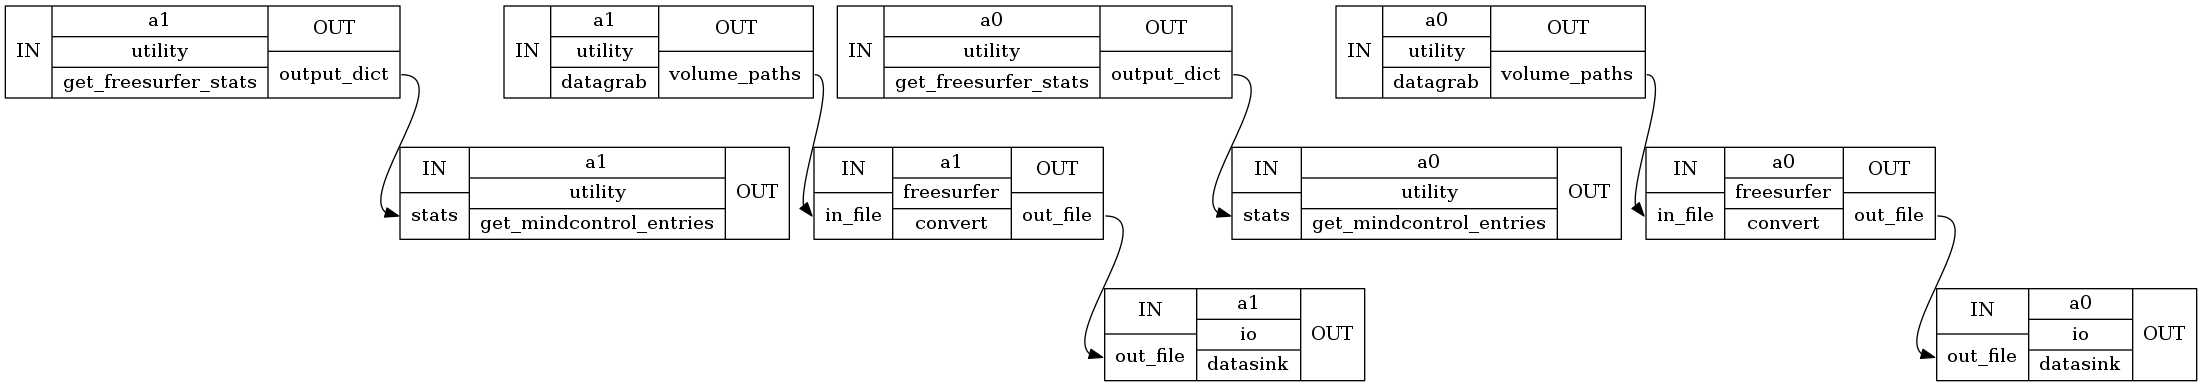

In [53]:
Image(os.path.join(workflow_working_dir, 'MindPrepFS/graph_detailed.dot.png'))

## Load JSON entries into the Mindcontrol database:

In [6]:
def get_collection(port=3001):
    from pymongo import MongoClient
    client = MongoClient("localhost", port)
    db =  client.meteor
    collection = db.subjects
    return collection, client

In [30]:
#import a json file reader
from nipype.utils.filemanip import load_json

#get the mongo database collection
coll, cli = get_collection()

#for subject's entry file, load the data and insert or update it into the database
for entry_file in glob(os.path.join(mindcontrol_outdir,"*","mindcontrol_entries.json")):
    data = load_json(entry_file)
    for d in data:
        name, entry_type = d["name"], d["entry_type"]
        query = {"name": name, "entry_type": entry_type}
        res = coll.find_one(query)
        #if the entry for a subject/entry_type does not exist, insert it:
        if not res:
            coll.insert_one(d)
        #if the entry exists, simply update it
        else:
            coll.update_one(query, {"$set": d})
        
    

Navigate to http://localhost:3000, You should now see something like:
    
![](images/freesurfer_instance.png)

## Applying painter edits to files

Open the QC viewer of a Brainmask file (click on an entry in the Freesurfer ID column), sign in, and click on the Painter pencil icon. I zoomed in (using alt+left click and drag) and erased an arbitrary chunk of voxels of the brainmask, and also logged a point at the center of my erased blob (will be used to plot later):

![](images/paint_brainmask.png)

Remember to hit "Save" when you are done. Now we will load the world coordinates that we painted and apply them to the brainmask file:

#### Some more imports

In [32]:
import nibabel as nib
from os.path import join, exists, split
from dipy.tracking import utils
import numpy as np

#### function to load the nifti data using a database query

In [39]:
def get_segmentation_mask(db, query,mindcontrol_base_dir):
    cursor = db.find(query)
    results = []
    for item in cursor:
        results.append(item)
    
    assert(len(results) == 1)
    subject = results[0]

    return nib.load(join(mindcontrol_base_dir,subject["check_masks"][1]))

#### Converts world coordinates to numpy matrix indices

In [118]:
def convert_to_indices(streamline, aff, img):
    
    topoints = lambda x : np.array([[m["x"], m["y"], m["z"]] for m in x["world_coor"]])
    points_orig = topoints(streamline)
    points_nifti_space = list(utils.move_streamlines([points_orig], aff, input_space=aff))[0]
    from dipy.tracking._utils import _to_voxel_coordinates, _mapping_to_voxel
    lin_T, offset = _mapping_to_voxel(aff, None)
    idx = _to_voxel_coordinates(points_orig, lin_T, offset)
    return points_nifti_space, idx

#### Record the indices of points to paint and their new paint value

In [126]:
def get_points_to_paint(drawing, aff, img): 
    import pandas as pd
    df = pd.DataFrame()
    data = img.get_data()
    for d in drawing:
        if not "paintValue" in d.keys():
            continue
        pv = d["paintValue"]
        if len(d["world_coor"]):
            points_nii_space, trans_points = convert_to_indices(d, aff, img)
            tmp = []
            for i,ni in enumerate(trans_points):
                to_append = {"x": ni[0], "y":ni[1], "z": ni[2], "val": pv}

                #validate affine. 
                if len(d["world_coor"]) == len(d["matrix_coor"]):
                    old_val_client = d["matrix_coor"][i]["old_val"]
                    true_val = data[ni[0], ni[1], ni[2]]
                    assert old_val_client == true_val, "affine mismatch!"

                tmp.append(to_append)
            df = df.append(pd.DataFrame(tmp), ignore_index=True)
    if df.shape[0]:
        df.drop_duplicates(inplace=True)

    return df

#### Final function to read the database for coordinates, load the image data, apply the painter edits, and save the image

In [120]:
def create_paint_volume(mongo_port, query,mindcontrol_base_dir, outpath):
    coll, cli = get_collection(mongo_port)
    mask_img = get_segmentation_mask(coll,query, mindcontrol_base_dir)
    aff = mask_img.affine

    p1 = get_points_to_paint(coll.find_one(query)["painters"], aff, mask_img)

    data = mask_img.get_data()
    for idx, row in p1.iterrows():
        paint_value = row['val']
        x,y,z = row['x'], row['y'], row['z']
        data[x][y][z] = paint_value

    painted_image = nib.nifti1.Nifti1Image(data,aff,mask_img.header)
    painted_image.to_filename(outpath)
    return outpath

#### Run on sub-02:

In [121]:
outpath = create_paint_volume(3001, {"subject_id": "sub-02", 
                           "entry_type":"brainmask"},
                    mindcontrol_base_dir,
                   os.path.abspath("./mindcontrol_base_dir/freesurfer/sub-02/brainmask_edited.nii.gz"))

Lets make sure this worked by plotting in nilearn

In [122]:
entry = coll.find_one({"subject_id": "sub-02", "entry_type":"brainmask"})
idx = entry["loggedPoints"][0]["world_coor"]

In [123]:
from nilearn.plotting import plot_roi

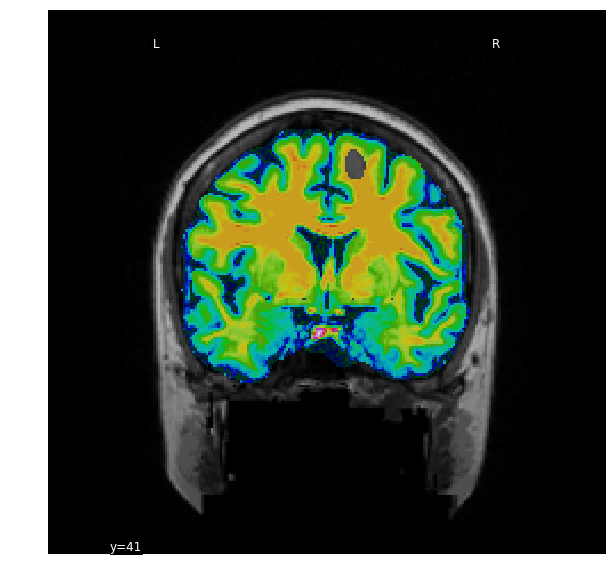

In [124]:
fig,ax = subplots(1,1,figsize=(10,10))
plot_roi(outpath, "./mindcontrol_base_dir/freesurfer/sub-02/T1.nii.gz", 
         cut_coords=[idx["y"]], display_mode="y", axes=ax)